In [8]:
from deepxde.nn.pytorch.deeponet import DeepONet
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define DeepONet operator for two-body trajectories
r = 64
operator_net = DeepONet(
    layer_sizes_branch=[6, 256, 256, 256, 256, r],  # q0_1, p0_1, q0_2, p0_2, m1, m2
    layer_sizes_trunk=[1, 256, 256, 256, 256, r],    # time t
    activation="sin",
    kernel_initializer=torch.nn.init.xavier_uniform_,
    num_outputs=4,
).to(device)

# initialize linear layers
def init_fn(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.0)

operator_net.apply(init_fn)

# optimizer setup
optimizer = optim.LBFGS(operator_net.parameters(), line_search_fn="strong_wolfe")

loss_track = []

# batch sampler for initial conditions and time
def sample_batch(batch_size, q0_range, p0_range, m1_range, m2_range, t_range):
    q0_1 = torch.empty(batch_size,1).uniform_(*q0_range).to(device)
    p0_1 = torch.empty(batch_size,1).uniform_(*p0_range).to(device)
    q0_2 = torch.empty(batch_size,1).uniform_(*q0_range).to(device)
    p0_2 = torch.empty(batch_size,1).uniform_(*p0_range).to(device)
    m1   = torch.empty(batch_size,1).uniform_(*m1_range).to(device)
    m2   = torch.empty(batch_size,1).uniform_(*m2_range).to(device)
    t    = torch.empty(batch_size,1).uniform_(*t_range).to(device)
    t.requires_grad_(True)
    return q0_1, p0_1, q0_2, p0_2, m1, m2, t

# training closure with physics informed losses
def closure():
    optimizer.zero_grad()

    q0_1_b, p0_1_b, q0_2_b, p0_2_b, m1_b, m2_b, t_b = sample_batch(
        batch_size=4096,
        q0_range=(-10,10),
        p0_range=(-10,10),
        m1_range=(1.0,1.0),
        m2_range=(1.0,1.0),
        t_range=(0.0,10.0),
    )

    branch = torch.cat((q0_1_b, p0_1_b, q0_2_b, p0_2_b, m1_b, m2_b), dim=1)
    u = operator_net((branch, t_b))  # [B,4]
    q1_pred, p1_pred, q2_pred, p2_pred = u[:,0:1], u[:,1:2], u[:,2:3], u[:,3:4]

    ones = torch.ones_like(q1_pred)
    dq1_dt = torch.autograd.grad(q1_pred, t_b, grad_outputs=ones, create_graph=True)[0]
    dp1_dt = torch.autograd.grad(p1_pred, t_b, grad_outputs=ones, create_graph=True)[0]
    dq2_dt = torch.autograd.grad(q2_pred, t_b, grad_outputs=ones, create_graph=True)[0]
    dp2_dt = torch.autograd.grad(p2_pred, t_b, grad_outputs=ones, create_graph=True)[0]

    # residuals for canonical equations
    r_q1 = dq1_dt - p1_pred / m1_b
    r_q2 = dq2_dt - p2_pred / m2_b

    # gravitational interaction
    G = 1.0
    delta_q = q2_pred - q1_pred
    dist3   = torch.abs(delta_q) ** 3 + 1e-8
    F1 = G * m1_b * m2_b * delta_q / dist3
    F2 = -F1

    r_p1 = dp1_dt - F1
    r_p2 = dp2_dt - F2
    loss_phys = torch.mean(r_q1**2 + r_q2**2 + r_p1**2 + r_p2**2)

    # initial condition loss
    u0 = operator_net((branch, torch.zeros_like(t_b)))
    q1_0, p1_0, q2_0, p2_0 = u0[:,0:1], u0[:,1:2], u0[:,2:3], u0[:,3:4]
    loss_ic = torch.mean((q1_0 - q0_1_b)**2 + (p1_0 - p0_1_b)**2
                         + (q2_0 - q0_2_b)**2 + (p2_0 - p0_2_b)**2)

    # energy conservation loss
    H0     = p0_1_b**2/(2*m1_b) + p0_2_b**2/(2*m2_b) - G*m1_b*m2_b/torch.abs(q0_2_b - q0_1_b)
    H_pred = p1_pred**2/(2*m1_b) + p2_pred**2/(2*m2_b) - G*m1_b*m2_b/torch.abs(q2_pred - q1_pred)
    loss_energy = torch.mean((H_pred - H0)**2)

    # symplectic gradient flow loss
    dH_dq1 = G*m1_b*m2_b * delta_q / dist3
    dH_dp1 = p1_pred / m1_b
    dH_dq2 = -G*m1_b*m2_b * delta_q / dist3
    dH_dp2 = p2_pred / m2_b

    dH_dt = dH_dq1 * dq1_dt + dH_dp1 * dp1_dt + dH_dq2 * dq2_dt + dH_dp2 * dp2_dt
    loss_gradflow = torch.mean(dH_dt**2)

    if torch.isnan(loss_phys) or torch.isnan(loss_ic) or torch.isnan(loss_energy) or torch.isnan(loss_gradflow):
        # print which component is NaN
        if torch.isnan(loss_phys):
            print("NaN in loss_phys")
        if torch.isnan(loss_ic):
            print("NaN in loss_ic")
        if torch.isnan(loss_energy):
            print("NaN in loss_energy")
        if torch.isnan(loss_gradflow):
            print("NaN in loss_gradflow")
        return torch.tensor(loss_track[-1]) if loss_track else torch.tensor(0.0)

    loss = loss_phys + loss_ic + loss_energy + loss_gradflow
    loss.backward()
    return loss

progress_1 = tqdm(range(5000), desc="Training with Adam")

# switch optimizer
optimizer_adam = optim.Adam(operator_net.parameters(), lr=1e-3)
for _ in progress_1:
    optimizer_adam.zero_grad()
    loss = closure()
    optimizer_adam.step()
    loss_track.append(loss.item())
    progress_1.set_postfix(Loss=loss_track[-1])

# then switch to L-BFGS for fine tuning
optimizer = optim.LBFGS(operator_net.parameters(), line_search_fn="strong_wolfe")

progress_2 = tqdm(range(500), desc="Fine-tuning with L-BFGS")
# training loop
for _ in progress_2:
    optimizer.step(closure)
    loss_track.append(closure().item())
    progress_2.set_postfix(Loss=loss_track[-1])

# save model state
torch.save(operator_net.state_dict(), "model-state-dicts/deep_onet_two_body_operator.pth")

Training with Adam:   0%|          | 0/5000 [00:00<?, ?it/s]

Fine-tuning with L-BFGS:   0%|          | 1/500 [00:00<02:51,  2.91it/s, Loss=4.01e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:   0%|          | 2/500 [00:01<06:19,  1.31it/s, Loss=4.68e+7]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:   6%|▌         | 31/500 [00:11<02:51,  2.73it/s, Loss=7.29e+8] 

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_g

Fine-tuning with L-BFGS:   6%|▋         | 32/500 [00:12<03:30,  2.22it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:   8%|▊         | 38/500 [00:12<01:03,  7.25it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:   9%|▉         | 44/500 [00:12<00:35, 12.96it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  10%|█         | 50/500 [00:13<00:24, 18.10it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  11%|█         | 53/500 [00:13<00:22, 20.00it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  12%|█▏        | 59/500 [00:13<00:19, 22.91it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  13%|█▎        | 65/500 [00:13<00:17, 24.51it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  14%|█▍        | 71/500 [00:13<00:16, 25.40it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  15%|█▌        | 77/500 [00:14<00:16, 25.66it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  17%|█▋        | 83/500 [00:14<00:16, 25.98it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  17%|█▋        | 86/500 [00:14<00:15, 26.02it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  18%|█▊        | 92/500 [00:14<00:15, 25.98it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  20%|█▉        | 98/500 [00:15<00:15, 25.90it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  21%|██        | 104/500 [00:15<00:15, 26.23it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  22%|██▏       | 110/500 [00:15<00:14, 26.16it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  23%|██▎       | 116/500 [00:15<00:14, 25.70it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  24%|██▍       | 119/500 [00:15<00:14, 25.57it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  25%|██▌       | 125/500 [00:16<00:14, 25.71it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  26%|██▌       | 131/500 [00:16<00:14, 25.64it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  27%|██▋       | 137/500 [00:16<00:14, 25.83it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  29%|██▊       | 143/500 [00:16<00:13, 25.91it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  30%|██▉       | 149/500 [00:16<00:13, 26.10it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  30%|███       | 152/500 [00:17<00:13, 25.97it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  32%|███▏      | 158/500 [00:17<00:13, 25.36it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  33%|███▎      | 164/500 [00:17<00:13, 25.69it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  34%|███▍      | 170/500 [00:17<00:12, 25.88it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  35%|███▌      | 176/500 [00:18<00:12, 25.87it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  36%|███▌      | 179/500 [00:18<00:12, 25.81it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  37%|███▋      | 185/500 [00:18<00:12, 25.98it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  38%|███▊      | 191/500 [00:18<00:11, 26.09it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  39%|███▉      | 197/500 [00:18<00:11, 26.13it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  41%|████      | 203/500 [00:19<00:11, 26.17it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  42%|████▏     | 209/500 [00:19<00:11, 26.29it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  42%|████▏     | 212/500 [00:19<00:11, 26.08it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  44%|████▎     | 218/500 [00:19<00:10, 26.11it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  45%|████▍     | 224/500 [00:19<00:10, 25.94it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  46%|████▌     | 230/500 [00:20<00:10, 26.01it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  47%|████▋     | 236/500 [00:20<00:10, 25.91it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  48%|████▊     | 242/500 [00:20<00:10, 25.79it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  49%|████▉     | 245/500 [00:20<00:09, 25.86it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  50%|█████     | 251/500 [00:20<00:09, 25.87it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  51%|█████▏    | 257/500 [00:21<00:09, 25.80it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  53%|█████▎    | 263/500 [00:21<00:09, 25.75it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  54%|█████▍    | 269/500 [00:21<00:08, 26.01it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  55%|█████▌    | 275/500 [00:21<00:08, 25.96it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  56%|█████▌    | 278/500 [00:22<00:08, 25.88it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  57%|█████▋    | 284/500 [00:22<00:08, 25.98it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  58%|█████▊    | 290/500 [00:22<00:08, 25.88it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  59%|█████▉    | 296/500 [00:22<00:07, 25.91it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  60%|██████    | 302/500 [00:22<00:07, 26.12it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  62%|██████▏   | 308/500 [00:23<00:07, 26.28it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  62%|██████▏   | 311/500 [00:23<00:07, 26.06it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  63%|██████▎   | 317/500 [00:23<00:06, 26.16it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  65%|██████▍   | 323/500 [00:23<00:06, 26.20it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  66%|██████▌   | 329/500 [00:23<00:06, 26.26it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  67%|██████▋   | 335/500 [00:24<00:06, 26.41it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  68%|██████▊   | 341/500 [00:24<00:06, 26.34it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  69%|██████▉   | 344/500 [00:24<00:05, 26.10it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  70%|███████   | 350/500 [00:24<00:05, 25.83it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  71%|███████   | 356/500 [00:24<00:05, 25.91it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  72%|███████▏  | 362/500 [00:25<00:05, 25.54it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  74%|███████▎  | 368/500 [00:25<00:05, 25.61it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  75%|███████▍  | 374/500 [00:25<00:04, 25.62it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  75%|███████▌  | 377/500 [00:25<00:04, 25.51it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  77%|███████▋  | 383/500 [00:26<00:04, 25.59it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  78%|███████▊  | 389/500 [00:26<00:04, 25.95it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  79%|███████▉  | 395/500 [00:26<00:04, 26.08it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  80%|████████  | 401/500 [00:26<00:03, 26.07it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  81%|████████▏ | 407/500 [00:26<00:03, 25.96it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  82%|████████▏ | 410/500 [00:27<00:03, 25.86it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  83%|████████▎ | 416/500 [00:27<00:03, 25.69it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  84%|████████▍ | 422/500 [00:27<00:03, 25.58it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  86%|████████▌ | 428/500 [00:27<00:02, 25.92it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  87%|████████▋ | 434/500 [00:27<00:02, 26.21it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  88%|████████▊ | 440/500 [00:28<00:02, 26.33it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  89%|████████▊ | 443/500 [00:28<00:02, 26.31it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  90%|████████▉ | 449/500 [00:28<00:01, 26.26it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  91%|█████████ | 455/500 [00:28<00:01, 26.10it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  92%|█████████▏| 461/500 [00:29<00:01, 26.04it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  93%|█████████▎| 467/500 [00:29<00:01, 26.22it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  95%|█████████▍| 473/500 [00:29<00:01, 26.02it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  95%|█████████▌| 476/500 [00:29<00:00, 25.76it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  96%|█████████▋| 482/500 [00:29<00:00, 25.75it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  98%|█████████▊| 488/500 [00:30<00:00, 25.89it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS:  99%|█████████▉| 494/500 [00:30<00:00, 26.01it/s, Loss=7.29e+8]

NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


Fine-tuning with L-BFGS: 100%|██████████| 500/500 [00:30<00:00, 16.41it/s, Loss=7.29e+8]


NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow
NaN in loss_phys
NaN in loss_ic
NaN in loss_energy
NaN in loss_gradflow


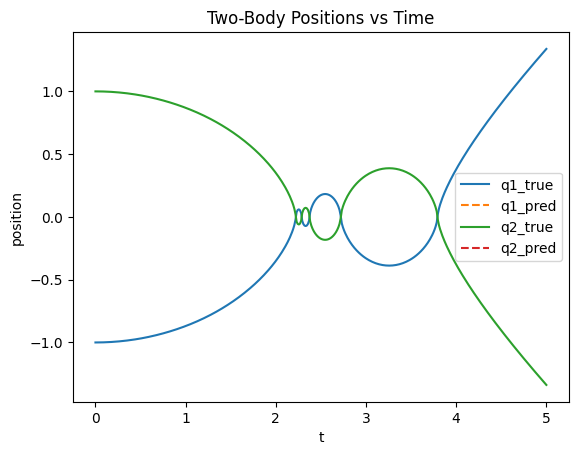

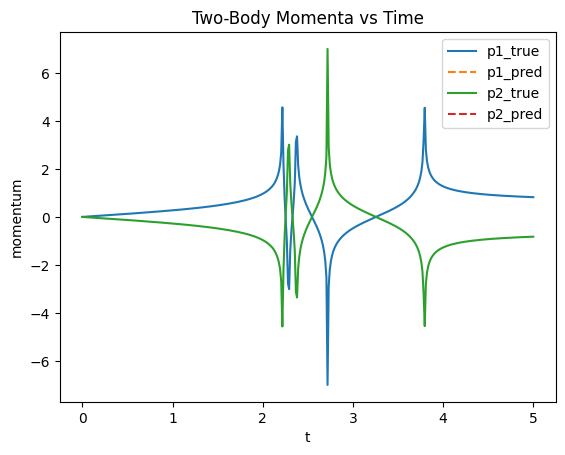

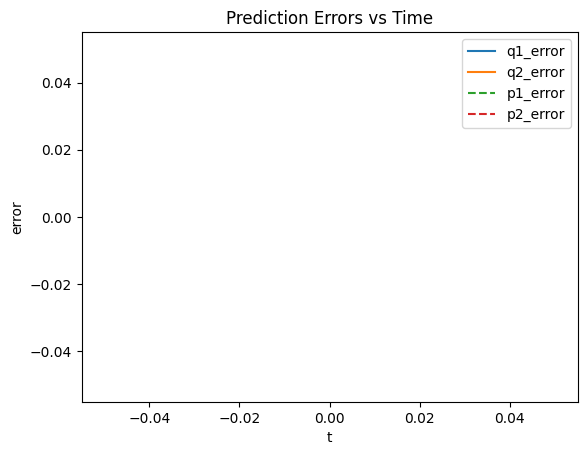

In [9]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from deepxde.nn.pytorch.deeponet import DeepONet

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# recreate trained operator for two-body
r = 64
operator_net = DeepONet(
    layer_sizes_branch=[6, 256, 256, 256, 256, r],  # q0_1, p0_1, q0_2, p0_2, m1, m2
    layer_sizes_trunk=[1, 256, 256, 256, 256, r],
    activation="sin",
    kernel_initializer=nn.init.xavier_uniform_,
    num_outputs=4,
).to(device)

# load saved weights
operator_net.load_state_dict(torch.load(
    "model-state-dicts/deep_onet_two_body_operator.pth", map_location=device
))
operator_net.eval()

# initial conditions and parameters
q0_1, p0_1 = -1.0, 0.0
q0_2, p0_2 =  1.0, 0.0
m1, m2 = 1.0, 1.0
G = 1.0

# time grid for evaluation
t_span = (0.0, 5.0)
t_eval = np.linspace(t_span[0], t_span[1], 400)

# true solution via SciPy
def two_body_ode(t, y):
    q1, p1, q2, p2 = y
    dq1dt = p1 / m1
    dq2dt = p2 / m2
    delta = q2 - q1
    denom = abs(delta) ** 3 + 1e-8
    dp1dt = G * m1 * m2 * delta / denom
    dp2dt = -G * m1 * m2 * delta / denom
    return [dq1dt, dp1dt, dq2dt, dp2dt]

y0 = [q0_1, p0_1, q0_2, p0_2]
sol = solve_ivp(two_body_ode, t_span, y0, t_eval=t_eval)
q1_true, p1_true, q2_true, p2_true = sol.y

# operator-net predictions
t_tensor = torch.tensor(
    t_eval.reshape(-1,1), dtype=torch.float32, device=device
)
branch = torch.tensor([
    [q0_1, p0_1, q0_2, p0_2, m1, m2]
] * len(t_eval), dtype=torch.float32, device=device)

with torch.no_grad():
    u_pred = operator_net((branch, t_tensor))
q1_pred = u_pred[:, 0].cpu().numpy()
p1_pred = u_pred[:, 1].cpu().numpy()
q2_pred = u_pred[:, 2].cpu().numpy()
p2_pred = u_pred[:, 3].cpu().numpy()

# plot positions
plt.figure()
plt.plot(t_eval, q1_true, label="q1_true")
plt.plot(t_eval, q1_pred, '--', label="q1_pred")
plt.plot(t_eval, q2_true, label="q2_true")
plt.plot(t_eval, q2_pred, '--', label="q2_pred")
plt.xlabel("t")
plt.ylabel("position")
plt.legend()
plt.title("Two-Body Positions vs Time")
plt.show()

# plot momenta
plt.figure()
plt.plot(t_eval, p1_true, label="p1_true")
plt.plot(t_eval, p1_pred, '--', label="p1_pred")
plt.plot(t_eval, p2_true, label="p2_true")
plt.plot(t_eval, p2_pred, '--', label="p2_pred")
plt.xlabel("t")
plt.ylabel("momentum")
plt.legend()
plt.title("Two-Body Momenta vs Time")
plt.show()

# plot errors
plt.figure()
plt.plot(t_eval, q1_pred - q1_true, label="q1_error")
plt.plot(t_eval, q2_pred - q2_true, label="q2_error")
plt.plot(t_eval, p1_pred - p1_true, '--', label="p1_error")
plt.plot(t_eval, p2_pred - p2_true, '--', label="p2_error")
plt.xlabel("t")
plt.ylabel("error")
plt.legend()
plt.title("Prediction Errors vs Time")
plt.show()
